# Clustering based classification - Resting State v/s Deep Breathing EEG

In [94]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy import signal
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from scipy.spatial import distance
import time
from progressbar import progressbar
from numba import jit

In [95]:
no_of_train_subject = 23
no_of_test_subject = 6
elec_name = ["Time", "F3","Fz","F4","FC1","FC2","C3","C4","CP1","CP2"]
no_of_clusters = 9

In [96]:
#source_file_RS = '../dataset/Merged_RS_Rejected.txt' #7501 EEG states per subject
#source_file_DB = '../dataset/Merged_DB_Rejected.txt' #7501 EEG states per subject

source_file_RS = '../dataset/RS_filter.txt'
source_file_DB = '../dataset/DB_filter.txt'

In [97]:
Time_a, Fp1_a, Fz_a, F3_a, F7_a, FT9_a, FC5_a, FC1_a, C3_a, T7_a, TP9_a, CP5_a, CP1_a, Pz_a, P3_a, P7_a, O1_a, Oz_a, O2_a, P4_a, P8_a, TP10_a, CP6_a, CP2_a, C4_a, T8_a, FT10_a, FC6_a, FC2_a, F4_a, F8_a, Fp2_a = np.loadtxt( 
    source_file_RS, 
    skiprows = 1, #If top title row present
    unpack = True)
Time_b, Fp1_b, Fz_b, F3_b, F7_b, FT9_b, FC5_b, FC1_b, C3_b, T7_b, TP9_b, CP5_b, CP1_b, Pz_b, P3_b, P7_b, O1_b, Oz_b, O2_b, P4_b, P8_b, TP10_b, CP6_b, CP2_b, C4_b, T8_b, FT10_b, FC6_b, FC2_b, F4_b, F8_b, Fp2_b = np.loadtxt( 
    source_file_DB,
    skiprows = 1, #If top title row present
    unpack = True)

In [98]:
elec_1_mat = np.stack((Time_a, F3_a, Fz_a, F4_a, FC1_a, FC2_a, C3_a, C4_a, CP1_a, CP2_a))
elec_2_mat = np.stack((Time_b, F3_b, Fz_b, F4_b, FC1_b, FC2_b, C3_b, C4_b, CP1_b, CP2_b))

## Adding values from Resting state for training & testing

In [99]:
training_mat_RS = np.zeros(shape=((7501*no_of_train_subject), (len(elec_name)-1)))
testing_mat_RS = np.zeros(shape=((7501*no_of_test_subject), (len(elec_name)-1)))

#Creating the resting state training matrix
for training in progressbar(range (no_of_train_subject)):
    for eeg_data in range (7501):
        eeg_state = np.array([])

        for i in range (1,len(elec_name)):
            eeg_state = np.append(eeg_state, elec_1_mat[i][eeg_data + (7501*training)])

        training_mat_RS = np.delete(training_mat_RS, (0), axis=0)#Make space cause using stack
        training_mat_RS = np.append(training_mat_RS,[eeg_state],axis= 0)

#Creating the resting state testing matrix
for testing in progressbar(range (no_of_test_subject)):
    for eeg_data in range (7501):
        eeg_state = np.array([])

        for i in range (1,len(elec_name)):
            eeg_state = np.append(eeg_state, elec_1_mat[i][eeg_data + (7501*(no_of_train_subject+testing))])

        testing_mat_RS = np.delete(testing_mat_RS, (0), axis=0)#Make space cause using stack
        testing_mat_RS = np.append(testing_mat_RS,[eeg_state],axis= 0)

100% (23 of 23) |########################| Elapsed Time: 0:14:26 Time:  0:14:26
100% (6 of 6) |##########################| Elapsed Time: 0:00:27 Time:  0:00:27


In [100]:
print (training_mat_RS)
print (training_mat_RS.shape)
print ("\n")
print (testing_mat_RS)
print (testing_mat_RS.shape)

[[ 4.5576  4.148   2.2371 ...  0.02    0.5762 -2.1798]
 [ 4.5062  4.1746  2.2779 ... -0.1713  0.2835 -2.0773]
 [ 4.4014  4.1558  2.2934 ... -0.3483 -0.013  -1.9466]
 ...
 [-1.6024 -1.1219  0.2574 ...  0.0396 -1.3971 -0.3723]
 [-1.5881 -1.2278  0.0451 ... -0.0192 -1.3504 -0.3348]
 [-1.5629 -1.3218 -0.1619 ... -0.0811 -1.294  -0.2997]]
(172523, 9)


[[-1.2427 -2.0707 -1.4615 ... -2.4415 -1.6264 -0.4128]
 [-1.1285 -1.9197 -1.5092 ... -2.5059 -1.4007 -0.5299]
 [-0.981  -1.724  -1.5236 ... -2.5469 -1.1582 -0.6457]
 ...
 [-0.0627  0.3412  0.7512 ... -0.8533  1.0798  0.3232]
 [-0.3371 -0.0115  0.6338 ... -0.3403  0.8194  0.2089]
 [-0.594  -0.3454  0.5193 ...  0.1764  0.5557  0.1092]]
(45006, 9)


## Adding values from Deep Breathing for training & testing

In [101]:
training_mat_DB = np.zeros(shape=((7501*no_of_train_subject), (len(elec_name)-1)))
testing_mat_DB = np.zeros(shape=((7501*no_of_test_subject), (len(elec_name)-1)))

#print ("Creating the deep breathing training matrix")
for training in progressbar(range (no_of_train_subject)):
    for eeg_data in range (7501):
        eeg_state = np.array([])
        
        for i in range (1,len(elec_name)):
            eeg_state = np.append(eeg_state, elec_2_mat[i][eeg_data + (7501*training)])
     
        training_mat_DB = np.delete(training_mat_DB, (0), axis=0)#Make space cause using stack
        training_mat_DB = np.append(training_mat_DB,[eeg_state],axis= 0)

#print ("Creating the deep breathing testing matrix")        
for testing in progressbar(range (no_of_test_subject)):
    for eeg_data in range (7501):
        eeg_state = np.array([])
        
        for i in range (1,len(elec_name)):
            eeg_state = np.append(eeg_state, elec_2_mat[i][eeg_data + (7501*(no_of_train_subject+testing))])
     
        testing_mat_DB = np.delete(testing_mat_DB, (0), axis=0)#Make space cause using stack
        testing_mat_DB = np.append(testing_mat_DB,[eeg_state],axis= 0)

100% (23 of 23) |########################| Elapsed Time: 0:14:09 Time:  0:14:09
100% (6 of 6) |##########################| Elapsed Time: 0:00:28 Time:  0:00:28


In [102]:
print (training_mat_DB)
print (training_mat_DB.shape)
print ("\n")
print (testing_mat_DB)
print (testing_mat_DB.shape)

[[-0.2903 -1.6875 -0.8463 ... -1.2129 -2.5774 -2.2581]
 [-0.4044 -1.7091 -0.8623 ... -1.0171 -2.4313 -2.0698]
 [-0.5132 -1.7158 -0.8736 ... -0.7886 -2.2547 -1.8503]
 ...
 [-2.1622 -1.5517 -1.0934 ...  0.5436  0.8859  1.0613]
 [-2.2056 -1.6561 -1.1939 ...  0.4355  0.7919  0.9739]
 [-2.2286 -1.7409 -1.2843 ...  0.3319  0.7086  0.8929]]
(172523, 9)


[[-0.519  -0.6456  0.049  ... -0.6515 -1.975  -1.5591]
 [-0.5353 -0.6268  0.0929 ... -0.7335 -2.0547 -1.7227]
 [-0.5513 -0.5985  0.1445 ... -0.8096 -2.1229 -1.8727]
 ...
 [-3.9314 -3.7511 -2.422  ... -1.0754  0.3369  0.8111]
 [-3.8149 -3.5907 -2.1473 ... -0.9859  0.0047  0.7802]
 [-3.6721 -3.4191 -1.8739 ... -0.901  -0.3254  0.7263]]
(45006, 9)


In [103]:
print (training_mat_RS.shape)
print (training_mat_DB.shape)

training_mat = np.concatenate((training_mat_RS, training_mat_DB))
testing_mat = np.concatenate((testing_mat_RS, testing_mat_DB))

(172523, 9)
(172523, 9)


## Double Cluster based classification

In [104]:
kmeans = KMeans(n_clusters=2, random_state=0)
km = kmeans.fit_predict(training_mat)

In [105]:
count_zero = 0
for i in range (7501*no_of_train_subject):
    if (km[i] == 0):
        count_zero = count_zero + 1
        
training_acc_RS = (count_zero/(7501*no_of_train_subject)) * 100
print ("Training accuracy of RS = ",training_acc_RS,"%")

count_one = 0
for i in range (7501*no_of_train_subject, len(km)):
    if (km[i] == 1):
        count_one = count_one + 1
        
training_acc_DB = (count_one/(7501*no_of_train_subject)) * 100
print ("Training accuracy of DB = ",training_acc_DB,"%")

Training accuracy of RS =  49.91798195023272 %
Training accuracy of DB =  49.961454414773684 %


In [106]:
testing_RS_count = 0
centroid = kmeans.cluster_centers_
for i in range (7501*no_of_test_subject):
    distance2rs = distance.euclidean(centroid[0], testing_mat_RS[i])  
    distance2db = distance.euclidean(centroid[1], testing_mat_RS[i])
    
    if (distance2rs <= distance2db):
        testing_RS_count = testing_RS_count + 1

testing_acc_RS = (testing_RS_count/(7501*no_of_test_subject) * 100)
print ("Testing accuracy of RS = ",testing_acc_RS,"%")

testing_DB_count = 0
centroid = kmeans.cluster_centers_
for i in range (7501*no_of_test_subject):
    distance2rs = distance.euclidean(centroid[0], testing_mat_DB[i])
    distance2db = distance.euclidean(centroid[1], testing_mat_DB[i])    
    
    if (distance2db <= distance2rs):
        testing_DB_count = testing_DB_count + 1

testing_acc_DB = (testing_DB_count/(7501*no_of_test_subject) * 100)
print ("Testing accuracy of DB = ",testing_acc_DB,"%")

Testing accuracy of RS =  50.553259565391286 %
Testing accuracy of DB =  50.248855708127806 %


## Multiple Cluster based classification

In [107]:
testing_acc = np.zeros(no_of_clusters)
y_axis_testing_acc = np.zeros(no_of_clusters)

for no_of_micro_clusters in progressbar(range (1,no_of_clusters+1)):
    kmeans = KMeans(n_clusters=no_of_micro_clusters, random_state=0)
    km = kmeans.fit_predict(training_mat_RS)
    centroid_RS = kmeans.cluster_centers_

    kmeans = KMeans(n_clusters=no_of_micro_clusters, random_state=0)
    km = kmeans.fit_predict(training_mat_DB)
    centroid_DB = kmeans.cluster_centers_
    
    
    testing_DB_count = 0
    micro_distance2rs = np.zeros(no_of_micro_clusters)
    micro_distsnce2db = np.zeros(no_of_micro_clusters)

    for i in range (7501*no_of_test_subject):
        for j in range (no_of_micro_clusters):
            micro_distance2rs[j] = distance.euclidean(centroid_RS[j], testing_mat_DB[i])

        for j in range (no_of_micro_clusters):
            micro_distsnce2db[j] = distance.euclidean(centroid_DB[j], testing_mat_DB[i])

        min_d2rs = min (micro_distance2rs)
        min_d2db = min (micro_distsnce2db)

        if (min_d2db <= min_d2rs):
            testing_DB_count = testing_DB_count + 1

    testing_acc[no_of_micro_clusters-1] = ((testing_DB_count)/(7501*no_of_test_subject)) * 100
    y_axis_testing_acc[no_of_micro_clusters-1] = no_of_micro_clusters

100% (9 of 9) |##########################| Elapsed Time: 0:01:44 Time:  0:01:44


Clustering training RS and DB into [ 1 ] microstates each. Test classification accuracy = 49.71559347642537 %
Clustering training RS and DB into [ 2 ] microstates each. Test classification accuracy = 63.847042616540016 %
Clustering training RS and DB into [ 3 ] microstates each. Test classification accuracy = 57.22570323956806 %
Clustering training RS and DB into [ 4 ] microstates each. Test classification accuracy = 65.28907256810203 %
Clustering training RS and DB into [ 5 ] microstates each. Test classification accuracy = 63.1915744567391 %
Clustering training RS and DB into [ 6 ] microstates each. Test classification accuracy = 63.72928054037239 %
Clustering training RS and DB into [ 7 ] microstates each. Test classification accuracy = 64.24254543838599 %
Clustering training RS and DB into [ 8 ] microstates each. Test classification accuracy = 65.00688797049283 %
Clustering training RS and DB into [ 9 ] microstates each. Test classification accuracy = 64.8069146336044 %


Text(0.5, 1.0, 'Deep Breathing Classification Accuracy')

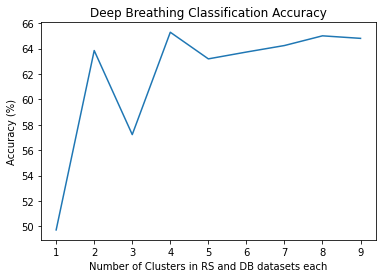

In [108]:
for i in range (no_of_clusters):   
    print ("Clustering training RS and DB into [",i+1,"] microstates each. Test classification accuracy =",testing_acc[i],"%")

plt.plot(y_axis_testing_acc, testing_acc)
plt.xlabel('Number of Clusters in RS and DB datasets each')
plt.ylabel('Accuracy (%)')
plt.title('Deep Breathing Classification Accuracy')

In [109]:
testing_acc = np.zeros(no_of_clusters)
y_axis_testing_acc = np.zeros(no_of_clusters)

for no_of_micro_clusters in progressbar(range (1,no_of_clusters+1)):
    kmeans = KMeans(n_clusters=no_of_micro_clusters, random_state=0)
    km = kmeans.fit_predict(training_mat_RS)
    centroid_RS = kmeans.cluster_centers_

    kmeans = KMeans(n_clusters=no_of_micro_clusters, random_state=0)
    km = kmeans.fit_predict(training_mat_DB)
    centroid_DB = kmeans.cluster_centers_
    
    
    testing_RS_count = 0
    micro_distance2rs = np.zeros(no_of_micro_clusters)
    micro_distsnce2db = np.zeros(no_of_micro_clusters)

    for i in range (7501*no_of_test_subject):
        for j in range (no_of_micro_clusters):
            micro_distance2rs[j] = distance.euclidean(centroid_RS[j], testing_mat_RS[i])

        for j in range (no_of_micro_clusters):
            micro_distsnce2db[j] = distance.euclidean(centroid_DB[j], testing_mat_RS[i])

        min_d2rs = min (micro_distance2rs)
        min_d2db = min (micro_distsnce2db)

        if (min_d2rs <= min_d2db):
            testing_RS_count = testing_RS_count + 1

    testing_acc[no_of_micro_clusters-1] = ((testing_RS_count)/(7501*no_of_test_subject)) * 100
    y_axis_testing_acc[no_of_micro_clusters-1] = no_of_micro_clusters

100% (9 of 9) |##########################| Elapsed Time: 0:01:34 Time:  0:01:34


Clustering training RS and DB into [ 1 ] microstates each. Test classification accuracy = 49.74447851397591 %
Clustering training RS and DB into [ 2 ] microstates each. Test classification accuracy = 47.118162022841396 %
Clustering training RS and DB into [ 3 ] microstates each. Test classification accuracy = 48.537972714749145 %
Clustering training RS and DB into [ 4 ] microstates each. Test classification accuracy = 46.258276674221214 %
Clustering training RS and DB into [ 5 ] microstates each. Test classification accuracy = 46.840421277163045 %
Clustering training RS and DB into [ 6 ] microstates each. Test classification accuracy = 45.780562591654444 %
Clustering training RS and DB into [ 7 ] microstates each. Test classification accuracy = 47.38479313869262 %
Clustering training RS and DB into [ 8 ] microstates each. Test classification accuracy = 46.471581566902195 %
Clustering training RS and DB into [ 9 ] microstates each. Test classification accuracy = 44.194107452339686 %


Text(0.5, 1.0, 'Resting State Classification Accuracy')

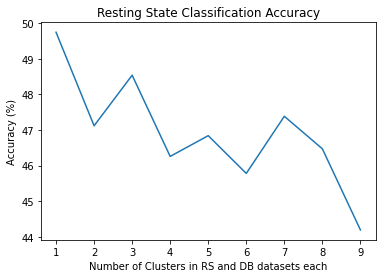

In [110]:
for i in range (no_of_clusters):   
    print ("Clustering training RS and DB into [",i+1,"] microstates each. Test classification accuracy =",testing_acc[i],"%")

plt.plot(y_axis_testing_acc, testing_acc)
plt.xlabel('Number of Clusters in RS and DB datasets each')
plt.ylabel('Accuracy (%)')
plt.title('Resting State Classification Accuracy')

## Binary Classification Neural Networks

In [111]:
label_RS = np.zeros(shape = (7501*no_of_train_subject,1))
label_DB = np.ones(shape = (7501*no_of_train_subject,1))
label_train = np.concatenate((label_RS, label_DB))

label_RS = np.zeros(shape = (7501*no_of_test_subject,1))
label_DB = np.ones(shape = (7501*no_of_test_subject,1))
label_test = np.concatenate((label_RS, label_DB))

In [112]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(12, input_dim=9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(training_mat, label_train, epochs=150, batch_size=10, verbose=0)

In [113]:
_, accuracy = model.evaluate(training_mat, label_train)
print('Training Accuracy: %.2f' % (accuracy*100))

_, accuracy = model.evaluate(testing_mat, label_test)
print('Testing Accuracy: %.2f' % (accuracy*100))

10783/10783 [==============================] - 9s 844us/step - loss: 0.1770 - accuracy: 0.9170
Training Accuracy: 91.70
2813/2813 [==============================] - 2s 808us/step - loss: 0.1963 - accuracy: 0.9097
Testing Accuracy: 90.97
